In [1]:
%load_ext autoreload
%autoreload 2

https://huggingface.co/datasets/fmplaza/EmoEvent

In [2]:
import review_analyzer.config as rt
import review_analyzer.plots as pt
import pandas as pd

In [3]:
emo_event_df = pd.read_csv(rt.EXTERNAL / 'emoevent_es.csv', sep="\t", encoding="utf-8")

In [4]:
pt.show_full_dataset(emo_event_df)

,id,tweet,emotion,offensive
0,1,Acabo de ver la gran pérdida que estamos teniendo en estos momentos en HASHTAG... La catedral de HASHTAG está en llamas😭Hoy la humanidad ha perdido otro gran monumento arquitectónico 😔 URL,sadness,0
1,2,USER ¿A que vamos a reconstruir Notre Dame antes de mandar un solo barco de salvamento al Mediterráneo... a que sí? HASHTAG URL,sadness,0
2,3,Desde ayer andan sufriendo por el incendio de HASHTAG y ni siquiera conocen la Basílica del voto nacional.,anger,0
3,4,"Muy afectada -como muchísima gente- por lo ocurrido a HASHTAG, lo llevo por dentro. Me gusta saber y estar informada pero no voy a recrearme viendo imágenes y escuchando ""información"" que solamente da vueltas a lo mismo una y otra vez",sadness,0
4,5,Es una mierda lo que paso en HASHTAG pero please dejen de subir su foto en HASHTAG 🙄😴,disgust,1
...,...,...,...,...
8404,8405,"Dembele es un imbécil, neta es increíble lo pendejo que está. HASHTAG HASHTAG",anger,1
8405,8406,HASHTAG Puta q son desagradables los wnes del Barca en especial Lucho Suarez wm! HASHTAG HASHTAG HASHTAG,anger,1
8406,8407,Puta que me cae mal Suárez ctm HASHTAG,anger,1
8407,8408,"Como te odio USER, odio tus comentarios filosóficos, tus sonidos detrás de mariano, tu fanatismo por el tiki tiki, tu falsa modestia... igual te quiero porq sos bostero! 😉 HASHTAG HASHTAG",anger,1


In [16]:
emotion_counts = emo_event_df['emotion'].value_counts()
emotion_counts

emotion
others      4127
joy         1815
sadness     1009
anger        857
surprise     344
disgust      161
fear          96
Name: count, dtype: int64

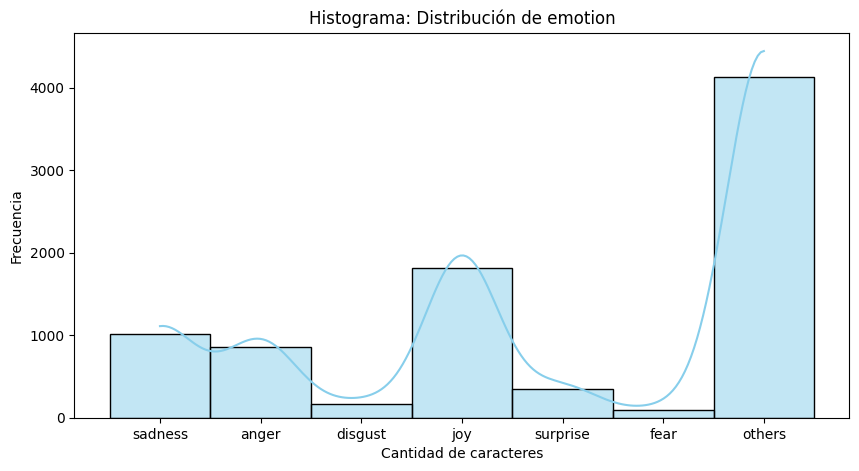

In [5]:
pt.plot_histo(emo_event_df, 'emotion')

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
emotion_ohe_df = pd.get_dummies(emo_event_df['emotion'])
df_encoded = pd.concat([emo_event_df[['tweet']], emotion_ohe_df], axis=1)
df_grouped = df_encoded.groupby('tweet').max().reset_index()

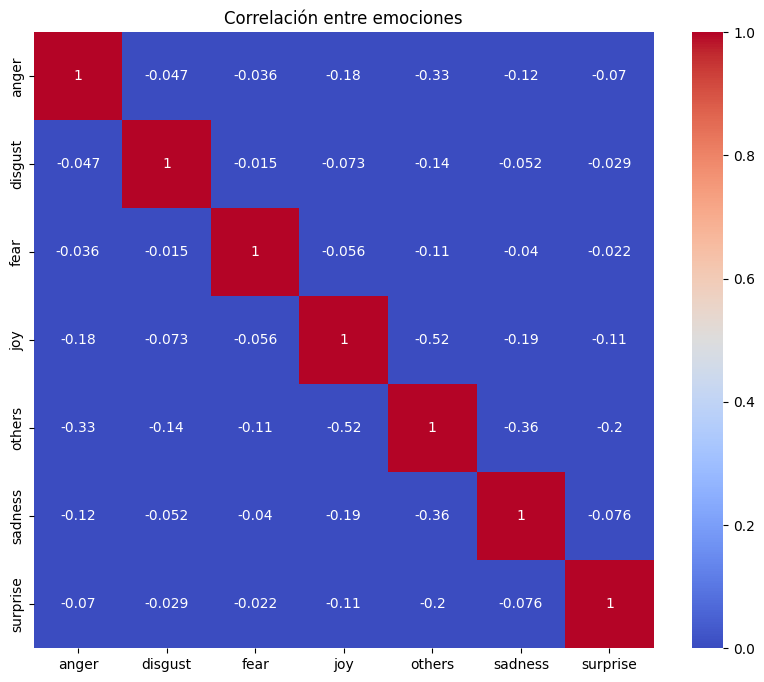

In [10]:
emotion_columns = emotion_ohe_df.columns
corr_matrix = df_grouped[emotion_columns].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlación entre emociones")
plt.show()

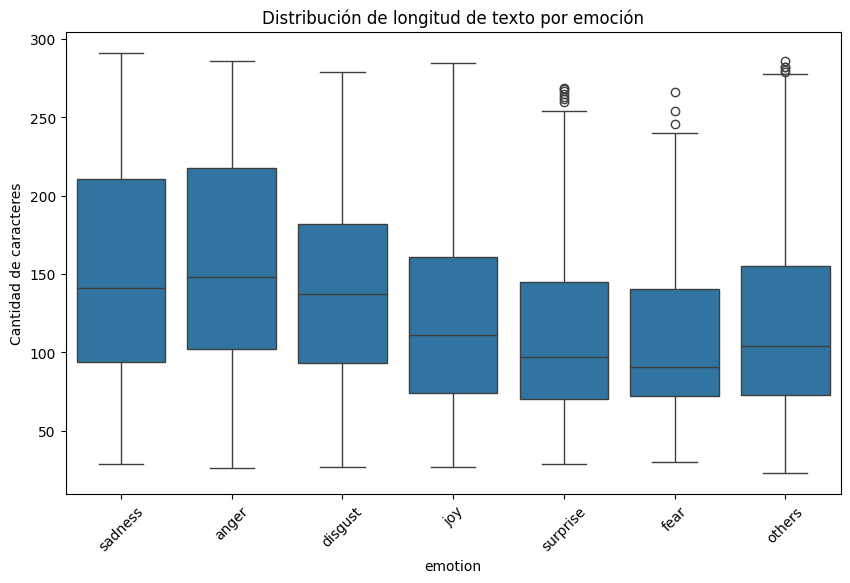

In [7]:
emo_event_df['char_length'] = emo_event_df['tweet'].str.len()

plt.figure(figsize=(10,6))
sns.boxplot(data=emo_event_df, x='emotion', y='char_length')
plt.title("Distribución de longitud de texto por emoción")
plt.ylabel("Cantidad de caracteres")
plt.xticks(rotation=45)
plt.show()

In [17]:
from transformers import BertForSequenceClassification, AutoTokenizer

In [18]:
emo_event_df.head()

,id,tweet,emotion,offensive,char_length
0,1,Acabo de ver la gran pérdida que estamos tenie...,sadness,0,189
1,2,USER ¿A que vamos a reconstruir Notre Dame ant...,sadness,0,128
2,3,Desde ayer andan sufriendo por el incendio de ...,anger,0,106
3,4,Muy afectada -como muchísima gente- por lo ocu...,sadness,0,234
4,5,Es una mierda lo que paso en HASHTAG pero plea...,disgust,1,85


In [3]:
from transformers import BertForSequenceClassification, AutoTokenizer
import torch
import os

In [4]:
model_path = "./modelo_multilabel_goemotions"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [71]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

In [72]:
texts = emo_event_df["tweet"].tolist()

In [73]:
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

In [74]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
dataloader = DataLoader(
    list(zip(tokenized_inputs["input_ids"], tokenized_inputs["attention_mask"])),
    batch_size=16,
    collate_fn=lambda batch: data_collator(
        {"input_ids": [x[0] for x in batch], "attention_mask": [x[1] for x in batch]}
    )
)

In [90]:
from tqdm import tqdm

print(f"Total de batches: {len(dataloader)}")

Total de batches: 526


In [75]:
all_probs = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Ejecutando inferencia"):
        outputs = model(**batch)
        probs = torch.sigmoid(outputs.logits)
        all_probs.append(probs)

all_probs = torch.cat(all_probs, dim=0).cpu()

In [76]:
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'embarrassment', 'excitement', 'fear', 'gratitude',
    'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
    'sadness', 'surprise', 'neutral', 'disgust'
]

In [77]:
threshold = 0.5

predicted_labels = []
for prob_row in all_probs:
    labels = [emotion_labels[i] for i, p in enumerate(prob_row) if p > threshold]
    predicted_labels.append(labels)

In [78]:
emo_event_df["pred_emotions"] = predicted_labels

In [80]:
import review_analyzer.plots as pl

In [87]:
pl.show_full_dataset(emo_event_df[["tweet", "emotion", "pred_emotions"]].sample(10, random_state=42))

,tweet,emotion,pred_emotions
4237,"El USER jugando mal, golea 3-0 al USER HASHTAG",others,"[disappointment, pride]"
7577,"HASHTAG HASHTAG ¿Por qué el Brexit, Bolsonaro, Trump, Orbán o Salvini en sus países sí y en España Vox no? El argumento de que en esos países hay gente muy mala, ignorante y fascista y en España no hay tanta es demasiado simple.",anger,"[annoyance, pride]"
4314,Klopp es lo mejor que le haya podido suceder al Liverpool. Se tenía que decir... HASHTAG,others,[admiration]
1022,HASHTAG HASHTAG No tiene vergüenza el presidente argentino doble moral. Alienta el golpe de estado en el país hermano y repudia un paro legítimo en su país tildando de golpistas a los trabajadores,anger,"[anger, annoyance, disapproval, embarrassment, pride]"
4938,Que orgulloso estoy de ser Español de bien. HASHTAG HASHTAG HASHTAG URL,joy,"[admiration, relief]"
5487,"Reino Unido declara el cambio climático como emergencia nacional URL HASHTAG HASHTAG HASHTAG HASHTAG via USER. RECIÉN SE DAN CUENTA, ESPEREMOS, QUE NO SEA DEMASIADO TARDE PARA ELLOS.",others,"[caring, pride, realization]"
4038,"Día del trabajador como se debe: en la cama, mirando la HASHTAG y tratando de no sufrir tanto por USER 💘",others,"[caring, pride, realization]"
6291,Hoy sé más porque he leído más... HASHTAG HASHTAG,others,"[pride, remorse]"
2517,🔴 Este HASHTAG tenemos un programa muy especial. ¡Y estrenamos horario! Ya puedes seguirlo en directo 😉👉 URL URL,others,"[admiration, fear, love]"
1287,USER Un pueblo unido jamas sera vencido HASHTAG animo les da el pueblo de HASHTAG,joy,"[desire, disapproval, pride, realization]"


In [86]:
pl.show_full_dataset(emo_event_df[["tweet", "emotion", "pred_emotions"]].sample(10, random_state=41))

,tweet,emotion,pred_emotions
6584,"Después de una gran noche del barca en HASHTAG, viene lo que viene.",others,"[fear, pride]"
7112,Pues se ha quedado buena noche después de que líderes y fieles enterraran por una vez en años sus diferencias para derrotar juntos a las fuerzas de la oscuridad... Hablo de HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG,others,"[admiration, pride]"
5331,¿Y los padres de HASHTAG? ¿Nada que decir? ¿Dónde están? ¿Orgullosos? ¿Hastiados? ¿Apartados?,others,"[confusion, curiosity]"
7198,"HASHTAG Es una pena que haya pasado esto, da mucha tristeza, espero que se recupere todo lo que se pueda, todo mi apoyo al pueblo parisino y francés",sadness,"[caring, realization, surprise, neutral]"
605,USER USER Lo que quiere hacer ver es que hay temas muchísimo mas graves donde mueren cientos de personas ahogadas y eso no abre telediarios ni los multimillonarios destinan cientos de millones de euros para paliar esos daños como si que lo hacen en casos com HASHTAG,anger,[pride]
4923,Si digo lo que pienso sobre las HASHTAG (y no me refiero solo a los resultados -que también- sino a las cosas que hace la gente) acabo detenida y en la Audiencia Nacional.,others,"[disappointment, pride]"
283,Resiste compañera!!!! Dolor al ver las imágenes de HASHTAG envuelta en llamas. Una pérdida mayúscula este símbolo de la arquitectura y la cultura gótica. 😢 URL,sadness,"[caring, neutral]"
7688,¿Cómo puede HASHTAG decir que no intervendrá en la situación de HASHTAG cuando HASHTAG es el más afectado por tal? ¿Qué tiene en la cabeza el presidente de México además de mierda?,anger,"[anger, annoyance, curiosity, pride]"
1159,HASHTAG Tanquetas militares arrollan a manifestantes en Caracas |VIDEO ► URL URL,fear,[pride]
7925,Y ahora como me duermo yo joder HASHTAG,anger,"[anger, annoyance, pride]"


In [88]:
pl.show_full_dataset(emo_event_df[["tweet", "emotion", "pred_emotions"]].sample(10, random_state=40))

,tweet,emotion,pred_emotions
85,RT si es PROVOCADO! !!!👉🏼🚨FAV si opinas que es sin querer 🔥 HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG URL,anger,[pride]
7448,"Muy triste por la terrible pérdida de un simbolo de la arquitectura tan espléndido. Siempre postergué viajar a Paris porq lo veia tan cerca q prefería otros lugares, y ahora cuando vaya, ya no estará. Y no soy católica, pero si creyente, pero no imagino París sin ella HASHTAG",sadness,"[disappointment, embarrassment, gratitude, joy, optimism, remorse, neutral]"
7563,No me lo puedo creer... vergonzoso. HASHTAG URL,anger,[excitement]
7918,Y así sigo... El puto mejor capítulo de la historia HASHTAG HASHTAG HASHTAG 😅 URL,joy,"[admiration, pride]"
4478,Me hubiese gustado una España teñida de morada pero no puedo ocultar mi orgullo de ver esta estampa👇 HASHTAG URL,joy,"[disappointment, nervousness, pride, relief]"
1257,"USER USER USER Puñado de infelices son HASHTAG indolentes a la destrucción de HASHTAG su República, arrodillados cumpliendo órdenes de sus patrones de HASHTAG y HASHTAG USER USER USER USER USER USER USER USER USER USER",sadness,"[anger, pride]"
5279,"HASHTAG ¡Perú! Porque este grave problema es de todos, salimos a las calles a protestar por el HASHTAG USER USER USER HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG HASHTAG URL",others,"[anger, pride]"
6346,Así se vive el ganar un Campeonato. HASHTAG se levó su trofeo 34 de HASHTAG 🇪🇸 URL,others,"[admiration, love, pride]"
5241,"""La humanidad está en una encrucijada, debemos decidir qué camino queremos tomar"". Este Día Mundial de la Tierra te compartimos las palabras de HASHTAG en Londres, donde más de 831 personas han sido detenidas en manifestaciones no violentas contra el calentamiento global. URL",others,[pride]
1757,"Vamos a ver, que el HASHTAG es el mejor capítulo de la serie por ahora, no tiene discusión pero siendo sinceros, en los textos no se han matado mucho... HASHTAG HASHTAG USER URL",others,"[admiration, approval, disapproval]"


In [89]:
pl.show_full_dataset(emo_event_df[["tweet", "emotion", "pred_emotions"]].sample(10, random_state=39))

,tweet,emotion,pred_emotions
1549,Ahora mismo ya no se si me gusta mas HASHTAG o HASHTAG Me lo tengo que pensar!!!,others,[confusion]
8063,"Lo de Suárez es vergonzoso, un tío que no para de quejarse a todo Dios, menos jugar al fútbol mira que da por culo HASHTAG",anger,"[embarrassment, excitement]"
612,La Catedral Notre Dame 🖤😕 fui allí 📸 2005 i 2009 HASHTAG es muy tristeza. Es una gran pérdida para HASHTAG 🙏🏼 URL,sadness,[neutral]
4953,"Ante estos resultados, expectativa de avances decididos en lucha contra la pobreza infantil, protección de la infancia contra la violencia, equidad en la educación. Que la infancia encuentre en las coaliciones el lugar que necesita tener HASHTAG USER URL",joy,"[pride, realization]"
1290,Guardamos la esperanza que no de embajada Chilena sea por tener un lugar seguro para planear los pasos a seguir HASHTAG,others,"[approval, realization]"
3549,Cuál fue el peor gol fallado hoy en el HASHTAG HASHTAG HASHTAG,others,"[anger, disappointment, disapproval, embarrassment, pride]"
7730,"hay un idiota tarifado que habla que si los HASHTAG entran en HASHTAG la vuelven como Siria, no sabe que los cubanos de la volvieron mier......, no sabe que 3.000.000 se han ido, fantoche HASHTAG USER",anger,"[anger, annoyance, pride]"
3617,¿Quieres un análisis HASHTAG sobre el cruce de la HASHTAG entre el HASHTAG y el HASHTAG? En USER fuimos a HASHTAG e hicimos nuestra HASHTAG de manera más objetiva.👉 URL x HASHTAG] HASHTAG ⚽🇨🇺 URL,others,"[curiosity, pride]"
1129,guaidó ha cruzado todas las líneas rojas. Sus acciones irresponsables y criminales causan siempre desgracias personales. La cárcel es el lugar para los golpistas que atacan a la democracia venezolana HASHTAG,anger,"[annoyance, disappointment, disapproval, pride]"
6570,Si Barcelona no gana hoy 3-0 el Liverpool se lo va a afilar en la vuelta HASHTAG HASHTAG HASHTAG,others,[pride]


In [ ]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'embarrassment', 'excitement', 'fear', 'gratitude',
    'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
    'sadness', 'surprise', 'neutral', 'disgust'
]

In [ ]:
label2id = {label: idx for idx, label in enumerate(emotion_cols)}
id2label = {str(idx): label for label, idx in label2id.items()}

model.config.label2id = label2id
model.config.id2label = id2label

In [10]:
model.config.id2label

{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'embarrassment',
 '12': 'excitement',
 '13': 'fear',
 '14': 'gratitude',
 '15': 'grief',
 '16': 'joy',
 '17': 'love',
 '18': 'nervousness',
 '19': 'optimism',
 '20': 'pride',
 '21': 'realization',
 '22': 'relief',
 '23': 'remorse',
 '24': 'sadness',
 '25': 'surprise',
 '26': 'neutral',
 '27': 'disgust'}

In [13]:
import review_analyzer.config as config

model.save_pretrained(config.API_MODEL)
tokenizer.save_pretrained(config.API_MODEL)

('D:\\python\\ml\\feel-track\\api\\model\\tokenizer_config.json',
 'D:\\python\\ml\\feel-track\\api\\model\\special_tokens_map.json',
 'D:\\python\\ml\\feel-track\\api\\model\\vocab.txt',
 'D:\\python\\ml\\feel-track\\api\\model\\added_tokens.json',
 'D:\\python\\ml\\feel-track\\api\\model\\tokenizer.json')

In [ ]:
nuevos_textos = [
    "No entiendo nada de lo que pasa últimamente.",
    "¡Estoy tan feliz por la noticia!",
    "Otra vez se cayó el sistema, qué frustración."
]


In [ ]:
import torch

inputs = tokenizer(nuevos_textos, return_tensors="pt", padding=True, truncation=True, max_length=128)

with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.sigmoid(logits)

preds = (probs > 0.5).int().tolist()


In [ ]:
emotion_to_label = {
    'neutral': 'testimonio',
    'realization': 'testimonio',
    'pride': 'testimonio',
    'sadness': 'testimonio',

    'joy': 'satisfacción',
    'optimism': 'satisfacción',
    'relief': 'satisfacción',

    'curiosity': 'consulta',
    'confusion': 'consulta',

    'disappointment': 'decepción',
    'disapproval': 'decepción',

    'annoyance': 'queja',
    'anger': 'queja',

    'remorse': 'frustración',
    'nervousness': 'frustración',
    'sadness': 'frustración',
    'anger': 'frustración',

    'confusion': 'confusión',

    'surprise': 'sorpresa',

    'excitement': 'entusiasmo',
    'joy': 'entusiasmo',
    'optimism': 'entusiasmo'
}

emotion_labels = model.config.id2label.values() if hasattr(model.config, "id2label") else list(emotion_to_label.keys())
emotion_labels = list(emotion_labels)

In [ ]:
final_labels = []
for pred_row in preds:
    mapped = set()
    for i, val in enumerate(pred_row):
        if val == 1:
            emotion = emotion_labels[i]
            mapped_label = emotion_to_label.get(emotion)
            if mapped_label:
                mapped.add(mapped_label)
    final_labels.append(list(mapped))


In [ ]:
for txt, etiquetas in zip(nuevos_textos, final_labels):
    print(f"Texto: {txt}\n→ Etiquetas predichas: {etiquetas}\n")